<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1TRNaCfYstvcIQqoUSdukYQGF6LuyL7Tv" width=600 height=320/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. Автоэнкодеры


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [ ]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt


from tqdm import tqdm_notebook
from tqdm import tqdm
import os
import pandas as pd
import skimage.io
from skimage.transform import resize

import torchvision
%matplotlib inline

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind


data, attrs = fetch_dataset()

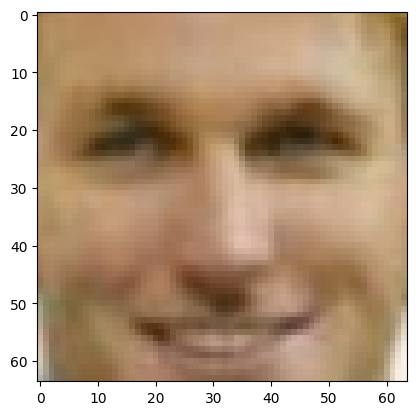

In [ ]:
plt.imshow( data[3])


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [ ]:


transforms =  torchvision.transforms.ToTensor()
from sklearn.model_selection import train_test_split

trans_data = []

for i in data :
  i = torch.FloatTensor(i)
  i = i.permute(2, 0, 1 )
  trans_data.append(i)
data_train , data_val = train_test_split( trans_data , train_size = 0.75 , random_state = 42)

In [ ]:
data_train[1].shape

torch.Size([3, 64, 64])

## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [ ]:
dim_code = 16 # выберите размер латентного вектора

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(3, 8, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=1, padding=1),
            nn.ReLU(True)
        )

        self.flatten = nn.Flatten()

        self.encoder_lin = nn.Sequential(
            nn.Linear(64 * 64  * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, dim_code )
        )


        self.decoder_lin = nn.Sequential(
            nn.Linear(dim_code , 128),
            nn.ReLU(True),
            nn.Linear(128, 64 * 64 * 32),
            nn.ReLU(True)
        )


        self.unflatten = nn.Unflatten(dim=1,
        unflattened_size=(32, 64, 64))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3,
            stride=1,  padding = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=1,
            padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 3, 3, stride=1,
            padding=1
           # ,
           # output_padding=1
            )
        )
    def encode(self, x):
        return self.encoder_lin(self.flatten(self.encoder_cnn(x)))

    def decode(self, x):
        return self.decoder_conv(self.unflatten(self.decoder_lin(x)))



    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)


        return x



In [ ]:
n_epochs = 5
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'


loss_fn = F.mse_loss

autoencoder = Autoencoder().to(device)

optimizer = torch.optim.AdamW( autoencoder.parameters(), lr=0.003)

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
train_loader = torch.utils.data.DataLoader( data_train , batch_size= 64)
val_loader = torch.utils.data.DataLoader( data_val , batch_size = 64 )

In [ ]:
pil = torchvision.transforms.ToPILImage() #

In [ ]:
val_img = []

train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for  X_batch in (pbar := tqdm( train_loader )):
        optimizer.zero_grad()
        reconstructed = autoencoder(X_batch.to(device))
        loss = loss_fn(reconstructed, X_batch.to(device))
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

        pbar.set_description(f'loss : {loss}')
    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch in val_loader:

          reconstructed = autoencoder(X_batch.to(device))
             # будут сохраняться фотки с последней эпохи.
          if epoch == 4 :
            for X in reconstructed :
                val_img.append(X)

          loss = loss_fn(reconstructed, X_batch.to(device))
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))




100%|██████████| 5/5 [00:39<00:00,  7.90s/it]


Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [ ]:
ind = 3285

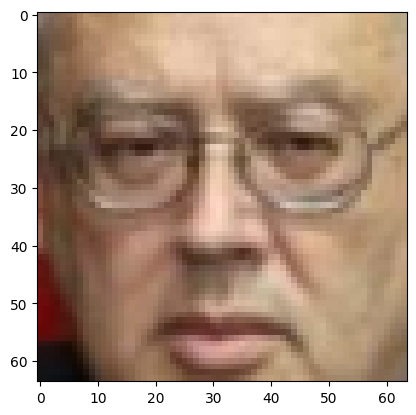

In [ ]:
img = pil(data_val[ind])
plt.imshow(img)

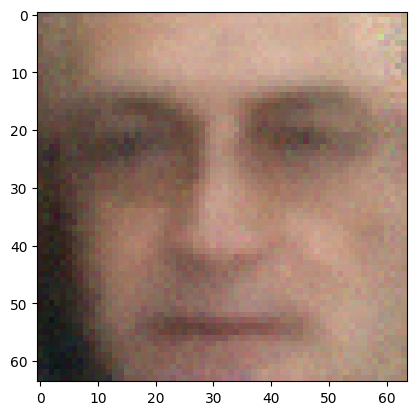

In [ ]:
img = pil(val_img[ind])
plt.imshow(img)

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [ ]:

std_mu, std_sigma = 0, 1
z = std_mu + std_sigma * np.random.randn(24, 16)
z = torch.from_numpy(z.astype('float32')).to(device)
# output = autoencoder.decode(z).detach().cpu()

# fig, axes = plt.subplots(3, 8, figsize=(16,8))
# for i, ax in enumerate(axes.flat):
#     ax.imshow(output[i].transpose(0,2).numpy())
#     ax.axis('off')

In [ ]:
output = autoencoder.decode(z)

In [ ]:
output.shape

torch.Size([24, 3, 64, 64])

In [ ]:
sample_img = []
for i in output :
    i = i.detach()
    i = i.cpu()
    i = pil(i)
    sample_img.append(i)


In [ ]:
len(sample_img)

24

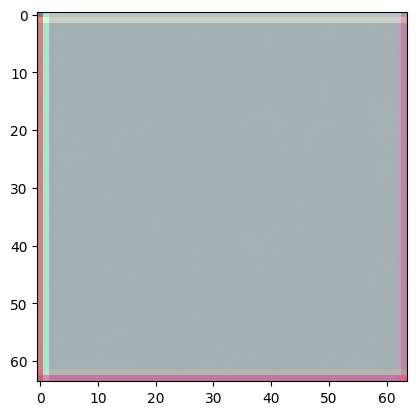

In [ ]:
plt.imshow(sample_img[0])

In [ ]:
# У меня не получилось!

## 1.5 Time to make fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
tnsr = torchvision.transforms.ToTensor()

In [ ]:
get_top_faces_by_category(attrs, attribute = 'Smiling', n =10)


[8643, 1816, 13034, 5624, 1045, 4681, 6139, 11797, 1359, 2031]

In [ ]:
def get_top_faces_by_category(df: pd.DataFrame, attribute: str, n: int=10):

    filtered_df = df.sort_values(by=attribute, ascending=False)[attribute]
    return filtered_df[:n].index.tolist()

def show_faces_by_category(category: str, n: int=10):

    faces = get_top_faces_by_category(attrs, category, n=n)
    fig, axes = plt.subplots(1, 10, figsize=(16,8))

    for ax, im in zip(axes.flat, data[faces]):
        ax.imshow(im)
        ax.set_title(category)
        ax.axis('off')

    plt.show()

def transform_faces_by_category(source_category: str, target_category: str, n: int=10):

    source_faces = get_top_faces_by_category(attrs, source_category, n=n)
    target_faces = get_top_faces_by_category(attrs, target_category, n=n)

    s = torch.Tensor(data[source_faces]).permute(0 ,3 , 1 , 2).to(device)

    t = torch.Tensor(data[target_faces]).permute(0 ,3 , 1 , 2).to(device)


    source_encoded = autoencoder.encode(s)
    target_encoded = autoencoder.encode(t)

    diff_vector = target_encoded.mean(axis=0) - source_encoded.mean(axis=0)

    result = autoencoder.decode((source_encoded + diff_vector))
    result.to(device)
    result = result.detach().cpu().data

    total =  []

    for i in result :
        i = pil(i)
        total.append(i)




    source = data[source_faces]



    fig, axes = plt.subplots(2, 10, figsize=(16, 8))

    for ax in axes.flat:
      for i, ax in enumerate(axes[0]):
        ax.imshow(source[i])
        ax.axis('off')
        ax.set_title('Original')
      for i, ax in enumerate(axes[1]):
        ax.imshow(total[i])
        ax.axis('off')
        ax.set_title('Transformed')

In [ ]:
data[0].shape

(64, 64, 3)

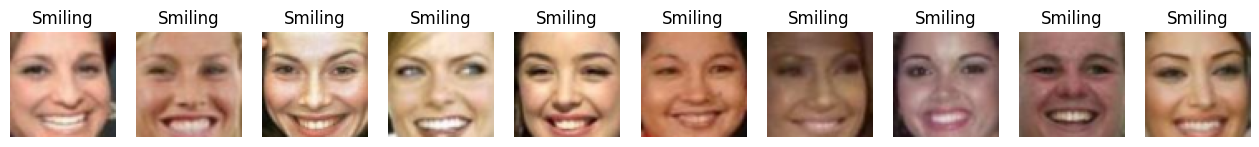

In [ ]:
show_faces_by_category('Smiling', n = 10)

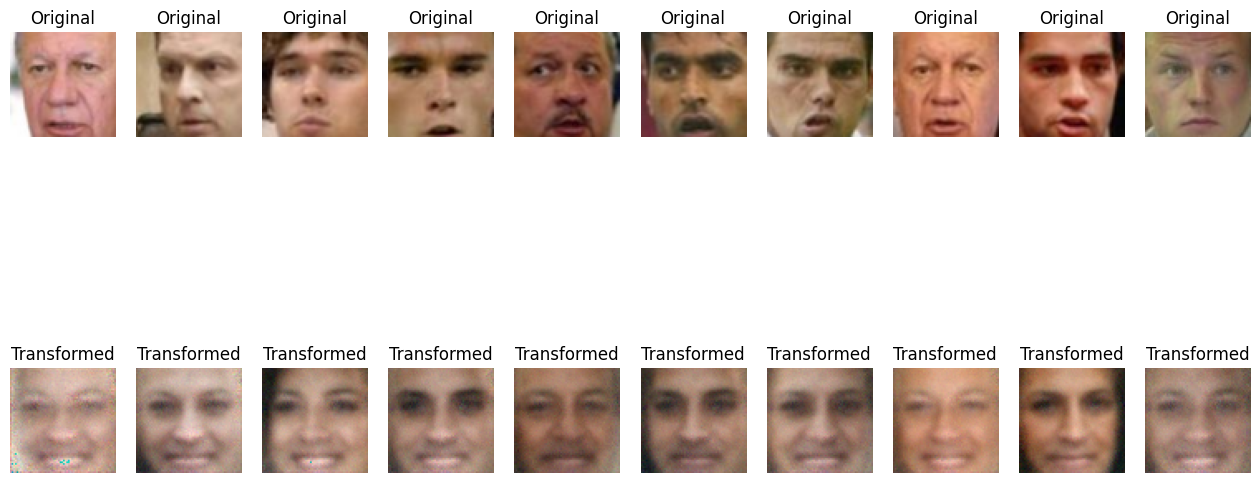

In [ ]:
transform_faces_by_category('Frowning', 'Smiling', n= 10)

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [ ]:
tnsr = torchvision.transforms.ToTensor()
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform = tnsr ,
                              # transform=transforms.ToTensor(),
                               download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform = tnsr ,
                             # transform=transforms.ToTensor(),
                              download=False)


In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels= 1 , out_channels= 32, kernel_size=3 , stride=2, padding=1),
            nn.BatchNorm2d( 32 , momentum = 0.1),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels= 32, out_channels= 64 , kernel_size= 3, stride=2, padding=1),
            nn.BatchNorm2d(64, momentum = 0.1),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels= 64, out_channels= 128 , kernel_size= 3 , stride=2, padding=1),
            nn.BatchNorm2d( 128 , momentum = 0.1),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels= 128, out_channels= 256, kernel_size= 3 , stride=2, padding=1),
            nn.BatchNorm2d(num_features = 256, momentum = 0.1),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels= 256, out_channels= 512, kernel_size= 3, stride=2, padding=1),
            nn.BatchNorm2d(num_features = 512, momentum = 0.1),
            nn.LeakyReLU())

        self.mu = nn.Linear(512, 2)

        self.logsigma = nn.Linear(512, 2)

        self.decoder_input = nn.Linear( 2 , 512)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels= 512 , out_channels= 256 , kernel_size= 3 , stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(num_features = 256, momentum = 0.1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels= 256, out_channels= 128 , kernel_size= 3 , stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(num_features = 128 , momentum = 0.1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels= 128, out_channels= 64 , kernel_size= 3 , stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(num_features = 64, momentum = 0.1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels= 64 , out_channels= 32, kernel_size= 3 , stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(num_features = 32, momentum = 0.1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels= 32, out_channels= 1, kernel_size= 3 , stride=2, padding=1, output_padding=1),
            nn.Sigmoid())

    def encode(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        mu = self.mu(x)
        logsigma = self.logsigma(x)
        return mu, logsigma

    def reparameterize(self, mu, logsigma):
        std = torch.exp(0.5 * logsigma)
        eps = torch.randn_like(std)
        sample = eps * std + mu
        return sample

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            samples = self.reparameterize(mu, logsigma)
            return samples
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z):
        z = self.decoder_input(z)
        z = z.view(-1, 512, 1, 1)
        reconstruction = self.decoder(z)
        return reconstruction



    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.reparameterize(mu, logsigma)
        reconstruction = self.decode(z)
        return reconstruction, mu, logsigma

    def get_latent_vector(self, x):
        mu, logsigma = self.encode(x)
        z = self.reparameterize(mu, logsigma)
        return z


Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:

def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [ ]:
criterion = loss_vae

autoencoder = VAE().to(device)

optimizer = torch.optim.AdamW( autoencoder.parameters(),lr= 3e-4, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-5, amsgrad=False)

In [ ]:

epochs = 5

In [ ]:

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size= 32, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size= 32, shuffle=False)

In [ ]:
rec_images = []

def train_vae(model, optimizer, criterion, epochs, train_loader, val_loader, is_scheduler=True):
    train_losses = []
    val_losses = []

    # Set default parameters for saving model weights
    #best_model_weights = model.state_dict()
    #best_loss_val = np.inf

    if is_scheduler:
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.95)

    for epoch in range(epochs):
        # Train mode
        model.train()
        train_losses_per_epoch = []
        for X_batch in (pbar := tqdm(train_loader)  ):
            optimizer.zero_grad()
            X_batch = X_batch[0].to(device)
            reconstructed, mu, logsigma = model(X_batch)
            loss = criterion(X_batch, mu, logsigma, reconstructed)
            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item())

        train_loss_mean = np.mean(train_losses_per_epoch)
        train_losses.append(train_loss_mean)

        if is_scheduler:
            scheduler.step()

        # Validation
        model.eval()
        val_losses_per_epoch = []
        with torch.no_grad():
            for X_batch_val in test_loader:
                X_batch_val = X_batch_val[0].to(device)
                reconstructed_val, mu_val, logsigma_val = model(X_batch_val)
                if epoch == 4:
                  rec_images.append(reconstructed_val)

                loss_val = criterion(X_batch_val, mu_val, logsigma_val, reconstructed_val)
                val_losses_per_epoch.append(loss_val.item())

        val_loss_mean = np.mean(val_losses_per_epoch)
        val_losses.append(np.mean(val_loss_mean))


In [ ]:
train_vae(model= autoencoder , optimizer=optimizer, criterion=criterion, epochs= 5 , train_loader=train_loader, val_loader=test_loader)

100%|██████████| 1875/1875 [00:19<00:00, 98.47it/s] 


[]

In [ ]:
img10_res = rec_images[0][0:10]

In [ ]:
img10_orig =[ test_dataset[0][0] ,
             test_dataset[1][0] ,
             test_dataset[2][0] ,
             test_dataset[3][0] ,
             test_dataset[4][0] ,
             test_dataset[5][0] ,
             test_dataset[6][0] ,
             test_dataset[7][0] ,
             test_dataset[8][0] ,
             test_dataset[9][0]   ]

In [ ]:
def show_picture(dataset):
  pic_box = plt.figure(figsize=(16,4))
  for i , img in enumerate(dataset) :
    if i< 10 :
      img = pil(img)
      pic_box.add_subplot(2,5,i+1)
      plt.imshow(img)


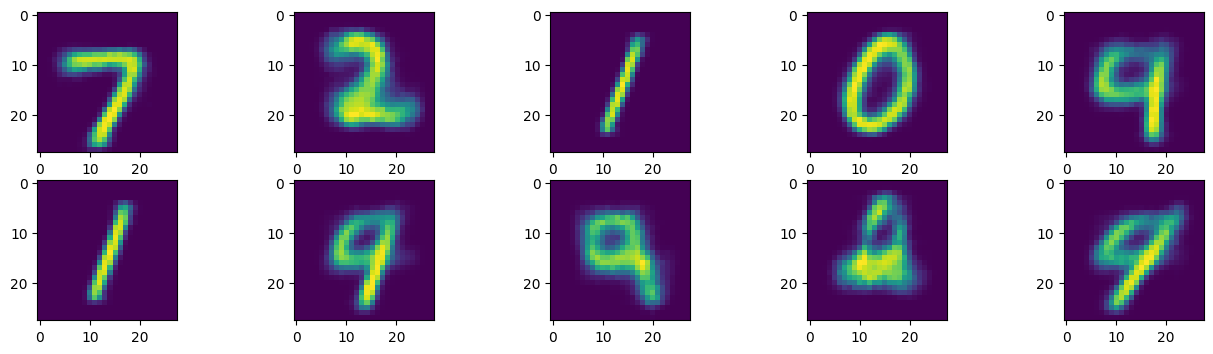

In [ ]:
show_picture( img10_res )

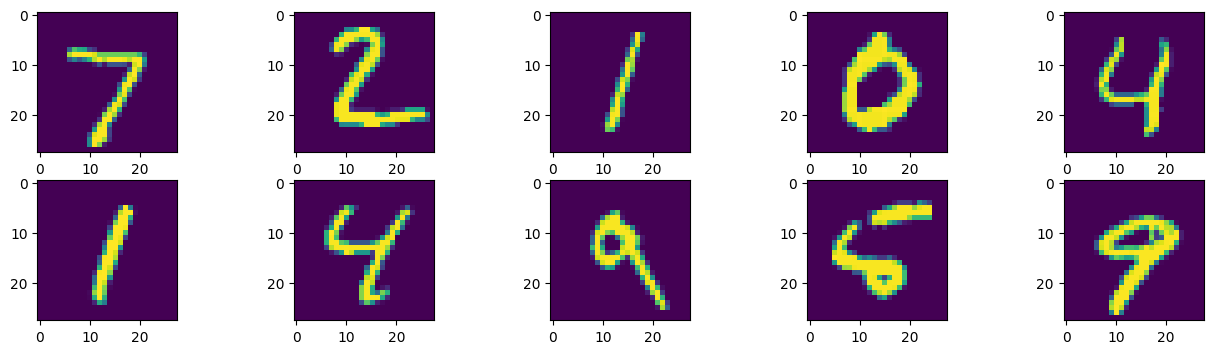

In [ ]:
show_picture(img10_orig)

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [ ]:
# ВЫШЕ!

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

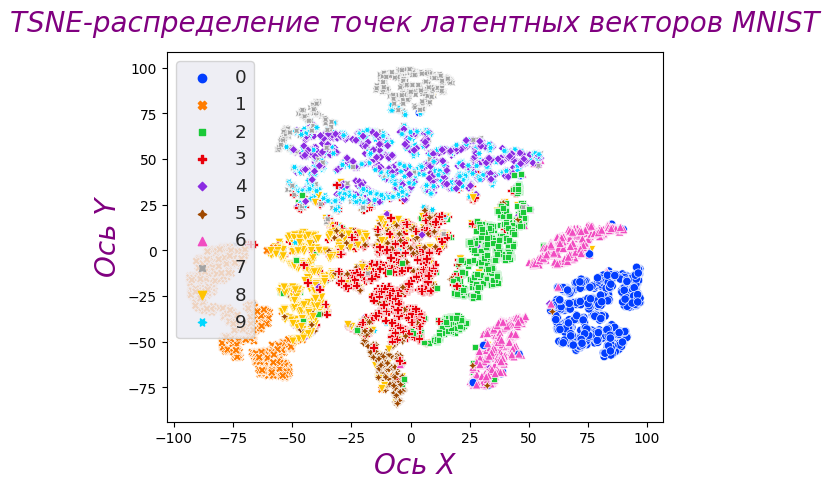

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

# Список всех меток
labels = [i[1] for i in test_dataset]

latents = torch.FloatTensor()
iterator = iter(test_loader)
for i in range(len(test_loader)):
    images = next(iterator)
    images = images[0]
    autoencoder.eval()
    with torch.no_grad():
        latent = autoencoder.get_latent_vector(images.to(device))
    latents = torch.cat((latents, latent.cpu()))

import warnings
warnings.filterwarnings("ignore")

latents_tsne = TSNE(n_components=2).fit_transform(latents)

fig, ax = plt.subplots()
sns.set(rc={'figure.figsize': (15, 8)}, font_scale=1.2, style='darkgrid')
sns.scatterplot(x = latents_tsne[:, 0], y = latents_tsne[:, 1], hue=labels, palette='bright', style=labels)
ax.set_title('TSNE-распределение точек латентных векторов MNIST', fontsize =20, color = 'purple', fontfamily = 'sans-serif', fontstyle = 'italic', pad = 15)
ax.set_xlabel('Ось X', fontsize =20, color = 'purple', fontfamily = 'sans-serif', fontstyle = 'italic')
ax.set_ylabel('Ось Y', fontsize =20, color = 'purple', fontfamily = 'sans-serif', fontstyle = 'italic')
plt.show()

Что вы думаете о виде латентного представления?

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [ ]:
# наиболее часто используемые параметры обучения
epochs = 100 # количество эпох обучения
lr = 3e-4 # базовое значение Learning Rate
init_channels = 32 # минимальный размер фильтров в сверточных слоях энкодера/декодера
image_channels = 1 # количество каналов изображения
cvae_latent_dim = 4 # размерность латентного вектора (скрытого пространства)
kernel_size = 3 # базовый размер сверточного ядра
batchNorm_momentum = 0.1 # параметры нормализации
num_classes = 10 # количество классов
img_size = 28 # размер изображения

In [ ]:
class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=image_channels, out_channels=init_channels, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(num_features = init_channels, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=init_channels, out_channels=init_channels*2, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(num_features = init_channels*2, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=init_channels*2, out_channels=init_channels*4, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(num_features = init_channels*4, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=init_channels*4, out_channels=init_channels*8, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(num_features = init_channels*8, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=init_channels*8, out_channels=init_channels*16, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(num_features = init_channels*16, momentum = batchNorm_momentum),
            nn.LeakyReLU())

        self.mu = nn.Linear(init_channels*16, cvae_latent_dim)

        self.logsigma = nn.Linear(init_channels*16, cvae_latent_dim)

        self.embed_class = nn.Linear(num_classes, img_size * img_size)

        # в in_channels добавлен дополнительный фильтр для меток (label)
        self.embed_data = nn.ConvTranspose2d(in_channels=image_channels + 1, out_channels=image_channels, kernel_size=1, padding=0, output_padding=0)

        self.decoder_input = nn.Linear(cvae_latent_dim + num_classes, init_channels*16)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=init_channels*16, out_channels=init_channels*8, kernel_size=kernel_size, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(num_features = init_channels*8, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=init_channels*8, out_channels=init_channels*4, kernel_size=kernel_size, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(num_features = init_channels*4, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(num_features = init_channels*2, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=init_channels*2, out_channels=init_channels, kernel_size=kernel_size, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(num_features = init_channels, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=init_channels, out_channels=image_channels, kernel_size=kernel_size, stride=2, padding=1, output_padding=1),
            nn.Sigmoid())

    def reparameterize(self, mu, logsigma):
        std = torch.exp(0.5 * logsigma)
        eps = torch.randn_like(std)
        sample = eps * std + mu
        return sample

    def encode(self, x, label):
        labels = F.one_hot(label, num_classes=10)
        labels = labels.type_as(torch.FloatTensor()).to(device)
        embedded_class = self.embed_class(labels)
        embedded_class = embedded_class.view(-1, 28, 28).unsqueeze(1)
        x = torch.cat([x, embedded_class], dim=1)
        x = self.embed_data(x)
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        mu = self.mu(x)
        logsigma = self.logsigma(x)
        return mu, logsigma, labels

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            samples = self.reparameterize(mu, logsigma)
            return samples
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z, label):
        labels = F.one_hot(label, num_classes=10)
        labels = labels.type_as(torch.FloatTensor()).to(device)
        z = torch.cat([z, labels], dim=1)
        z = self.decoder_input(z)
        z = z.view(-1, 512, 1, 1)
        reconstruction = self.decoder(z)
        return reconstruction


    def forward(self, x, label):
        mu, logsigma, labels = self.encode(x, label)
        z = self.reparameterize(mu, logsigma)
        z = torch.cat([z, labels], dim=1)
        z = self.decoder_input(z)
        z = z.view(-1, 512, 1, 1)
        reconstruction = self.decoder(z)
        return reconstruction, mu, logsigma

    def get_latent_vector(self, x, label):
        mu, logsigma, labels = self.encode(x, label)
        z = self.reparameterize(mu, logsigma)
        return z

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

In [ ]:
epochs = 5

In [ ]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform= tnsr, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform= tnsr, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
criterion = loss_vae
cvaeautoencoder = CVAE().to(device)
optimizer = torch.optim.AdamW(cvaeautoencoder.parameters(),lr=lr, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-5, amsgrad=False)

In [ ]:
val_images = []

def train_cvae(model, optimizer, criterion, epochs, train_loader, val_loader, is_scheduler=True):
    train_losses = []
    val_losses = []




    if is_scheduler:
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.95)

    for epoch in range(epochs):
        # Train mode
        model.train()

        train_losses_per_epoch = []
        for _, X_batch in (pbar := tqdm(enumerate(train_loader))):
            optimizer.zero_grad()
            images, labels = X_batch
            images = images.to(device)
            labels = labels.to(device)
            reconstructed, mu, logsigma = model(images, labels)
            loss = criterion(images, mu, logsigma, reconstructed)
            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item())

        train_loss_mean = np.mean(train_losses_per_epoch)
        train_losses.append(train_loss_mean)

        if is_scheduler:
            scheduler.step()

        # Validation
        model.eval()
        val_losses_per_epoch = []
        with torch.no_grad():
            for X_batch_val in val_loader:
                images_val, labels_val = X_batch_val
                images_val = images_val.to(device)
                labels_val = labels_val.to(device)
                reconstructed_val, mu_val, logsigma_val = model(images_val, labels_val)
                if epoch == 4 :
                    val_images.append(reconstructed_val)
                loss_val = criterion(images_val, mu_val, logsigma_val, reconstructed_val)
                val_losses_per_epoch.append(loss_val.item())

        val_loss_mean = np.mean(val_losses_per_epoch)
        val_losses.append(np.mean(val_loss_mean))

        # Save best model weights


In [ ]:
train_cvae(model=cvaeautoencoder, optimizer=optimizer, criterion=criterion, epochs=epochs, train_loader=train_loader, val_loader=test_loader)

1875it [00:20, 91.94it/s]
1875it [00:20, 91.45it/s]
1875it [00:20, 93.71it/s]
1875it [00:20, 92.28it/s]
1875it [00:20, 91.09it/s]


In [ ]:
val_images[0].shape

torch.Size([32, 1, 28, 28])

In [ ]:
reconstructed = []
for i in val_images[0] :
    reconstructed.append(i)


In [ ]:
len(reconstructed)

32

In [ ]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./mnist_data/
    Split: Test
    StandardTransform
Transform: ToTensor()

In [ ]:
def show_picture(dataset):
  pic_box = plt.figure( figsize=(16,4))
  for i , img in enumerate(dataset) :
    if i< 16 :
      img = pil(img)
      pic_box.add_subplot(2,8,i+1)
      plt.imshow(img)


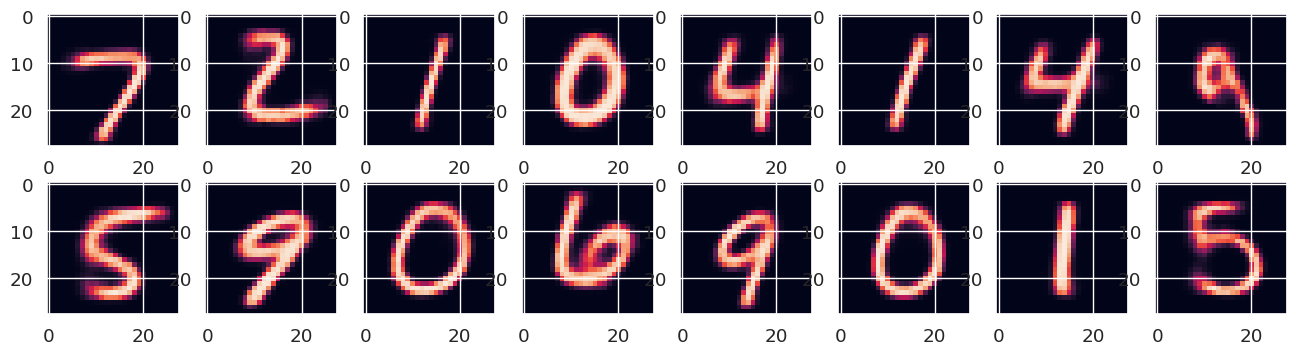

In [ ]:
show_picture(reconstructed) # сгенерированные цифры

In [ ]:
test_dataset_digits = []

for i in test_dataset :
    test_dataset_digits.append(i[0])

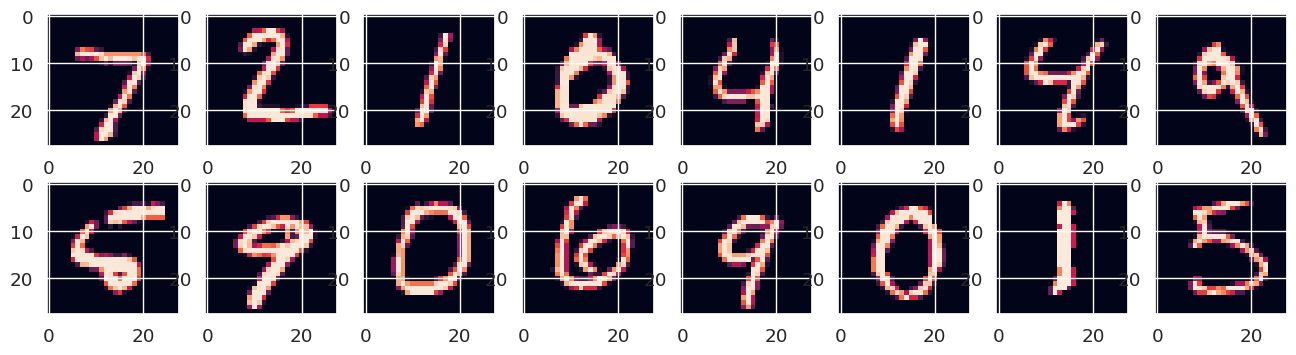

In [ ]:
pic_box = plt.figure( figsize=(16,4))
for i , img in enumerate(test_dataset_digits) :
    if i < 16 :
        img = pil(img)
        pic_box.add_subplot(2,8,i+1)
        plt.imshow(img)


# оригинальные цифры

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

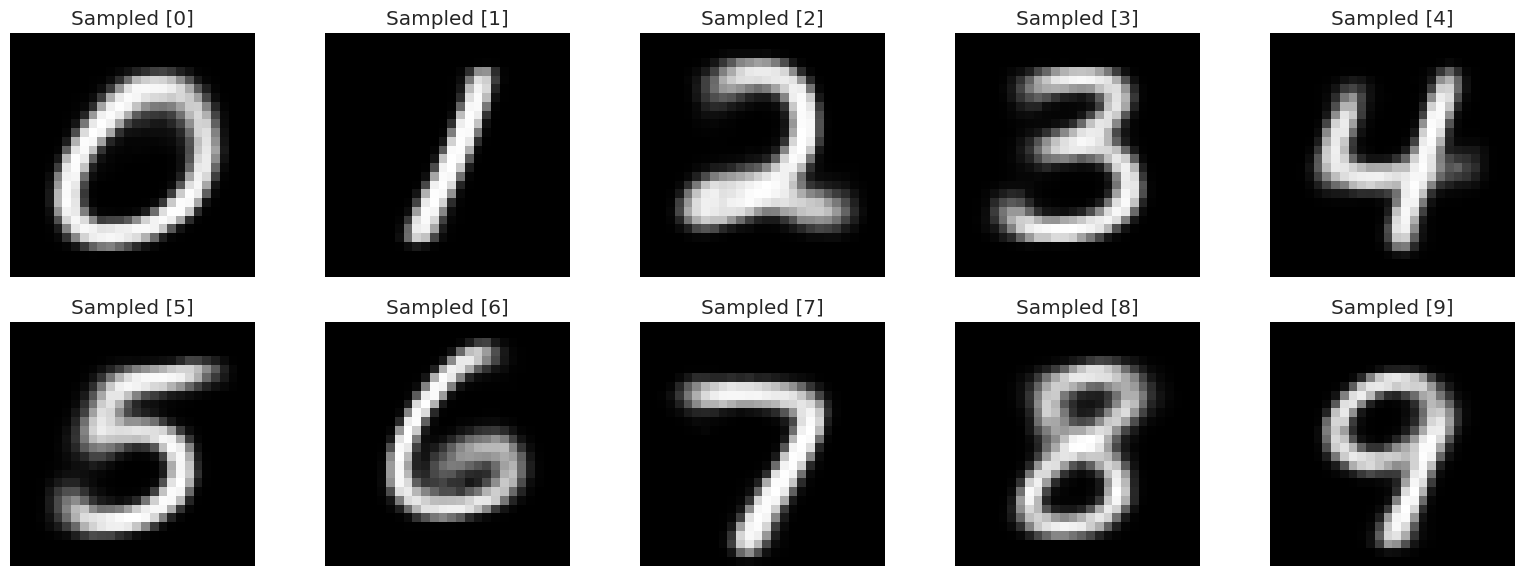

In [ ]:
z = torch.randn(1, cvae_latent_dim)
z = torch.tile(z, dims=(10, 1))
labels = torch.LongTensor(list(range(10)))
cvaeautoencoder.eval()
with torch.no_grad():
    output = cvaeautoencoder.decode(z.to(device), labels.to(device))
fig, ax = plt.subplots(2, 5, figsize=(16, 6))
for i in range(2):
    for j in range(5):
        axes = ax[i, j]
        axes.imshow(output[5*i+j].cpu().squeeze(0), cmap='gray')
        axes.set_title(f'Sampled {[5*i+j]}')
        axes.axis('off')
plt.tight_layout()
plt.show()

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

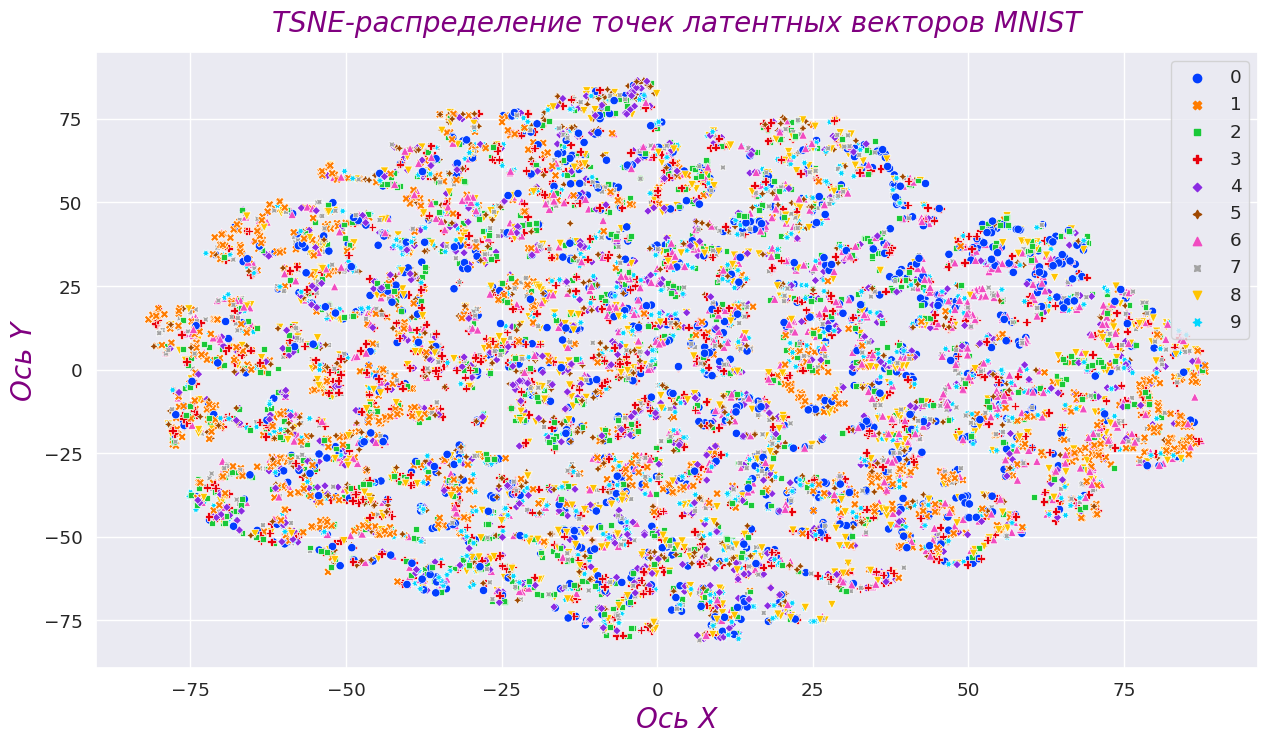

In [ ]:
latents = torch.FloatTensor()

for batch in test_loader:
    images, labels = batch
    cvaeautoencoder.eval()
    with torch.no_grad():
        latent = cvaeautoencoder.get_latent_vector(images.to(device), labels.to(device))
    latents = torch.cat((latents, latent.cpu()))

latents_tsne = TSNE(n_components=2).fit_transform(latents)


labels = [i[1] for i in test_dataset]
fig, ax = plt.subplots()
sns.set(rc={'figure.figsize': (15, 8)}, font_scale=1.2, style='darkgrid')
sns.scatterplot(x = latents_tsne[:, 0], y = latents_tsne[:, 1], hue=labels, palette='bright', style=labels)
ax.set_title('TSNE-распределение точек латентных векторов MNIST', fontsize =20, color = 'purple', fontfamily = 'sans-serif', fontstyle = 'italic', pad = 15)
ax.set_xlabel('Ось X', fontsize =20, color = 'purple', fontfamily = 'sans-serif', fontstyle = 'italic')
ax.set_ylabel('Ось Y', fontsize =20, color = 'purple', fontfamily = 'sans-serif', fontstyle = 'italic')
plt.show()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума.
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом.

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)

In [ ]:
<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>

In [ ]:
<тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>

  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат

    distances,neighbors = get_similar(image,n_neighbors=11)

    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")

    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>